In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, output
import sys
import time
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import shuffle

output.clear()
drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/'
output.clear()

In [2]:
df = pd.read_csv(drive_data_path+"adult.txt", sep=',', index_col=None, na_values='?')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48789 entries, 0 to 48840
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48789 non-null  int64 
 1   workclass       48789 non-null  object
 2   fnlwgt          48789 non-null  int64 
 3   education       48789 non-null  object
 4   education-num   48789 non-null  object
 5   marital-status  48789 non-null  object
 6   occupation      48789 non-null  object
 7   relationship    48789 non-null  object
 8   race            48789 non-null  object
 9   sex             48789 non-null  object
 10  capital-gain    48789 non-null  int64 
 11  capital-loss    48789 non-null  int64 
 12  hours-per-week  48789 non-null  int64 
 13  native-country  48789 non-null  object
 14  salary          48789 non-null  object
 15  capital-diff    48789 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 6.3+ MB


,age,fnlwgt,capital-gain,capital-loss,hours-per-week,capital-diff
count,48789.000000,4.878900e+04,48789.000000,48789.000000,48789.000000,48789.000000
mean,38.652791,1.896713e+05,1080.195269,87.597368,40.425895,992.597901
std,13.708633,1.056171e+05,7455.980687,403.213066,12.392856,7479.537231
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000,-4356.000000
25%,28.000000,1.175550e+05,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781400e+05,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376080e+05,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,99999.000000,4356.000000,99.000000,99999.000000


In [ ]:
df.describe(include="O")

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,native-country,salary
count,46042,48841,48841,48841,46032,48841,48841,48841,47984,48841
unique,8,16,16,7,14,6,5,2,41,2
top,Private,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,15784,22379,6172,19716,41761,32649,43831,37154


Признаки типа "объект" - это категориальные признаки. Остальные - численные.

Метод describe даёт краткое описание признаков.

В датасете могут быть повторябщиеся данные. Если их не много, то можно выкидывать, потому что они не представляют никакой ценности.

In [3]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    48789
True        52
dtype: int64


Необходимо посмотреть, в каких признаках встречаются пустые значения и какую часть занимают.

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
occupation,2805,5.7
workclass,2795,5.7
native-country,856,1.8
salary,0,0.0
hours-per-week,0,0.0


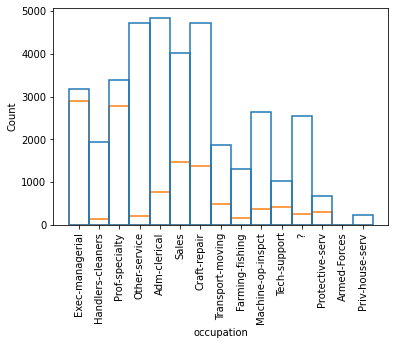

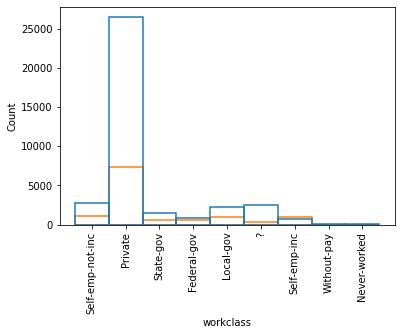

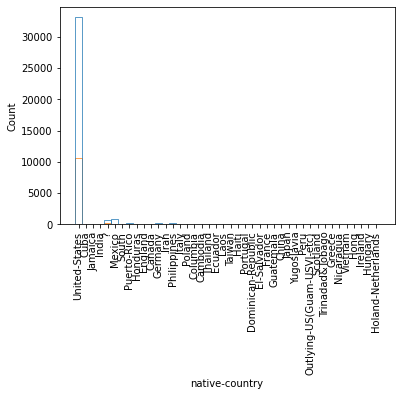

In [ ]:
for feat in ('occupation', 'workclass', 'native-country'):
  sns.histplot(x = feat, data = df.fillna('?'),  hue='salary', kde=False, element="bars",
    stat="count", common_norm=False, fill=False, legend=False)
  plt.xticks(rotation=90)
  plt.show()

Исходя из встречаемости пустых значений и соотношения классов в них можно сделать выводы:

1) страну происхождения можно не учитывать, т.к. есть существенный перекос встречаемости значений в пользу одной страны

2) можно рассмотреть три случая: 

а)оставить всё как есть, т.е. пустые значения - новое значение признака

б) присвоить пустым значениям похожее значение признака или самое встречаемое

г) удалить строки с пустыми значениями, что не является оптимальным решением проблемы

In [4]:
df_fill = df.copy()
df_fill['occupation'] = df_fill['occupation'].fillna('Machine-op-inspct')
df_fill['workclass'] = df_fill['workclass'].fillna('Private')
df_fill['native-country'] = df_fill['native-country'].fillna('United-States')

In [5]:
size1 = df.shape[0]
df_drop = df.dropna().copy()
print(size1, '-', size1-df_drop.shape[0], '=', df_drop.shape[0])
print('Deleted', (100*(size1-df_drop.shape[0]))//size1, '%')

df = df.fillna('?')

48789 - 3615 = 45174
Deleted 7 %


Классы не сбалансированы, их соотношение 3:1, что может повлечь за собой ухудшение качества некоторых моделей из-за статистической максимизации правильных ответов

<=50K    0.760713
>50K     0.239287
Name: salary, dtype: float64
<=50K    0.752151
>50K     0.247849
Name: salary, dtype: float64


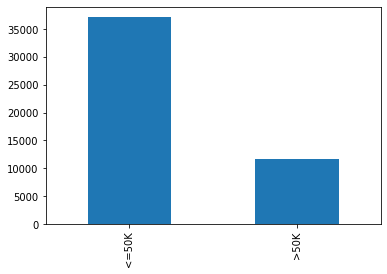

In [ ]:
#проверка сбалансированности классов
print(df['salary'].value_counts(normalize=True))
print(df_drop['salary'].value_counts(normalize=True))
df['salary'].value_counts().plot(kind='bar')

Для построения матрицы корреляции нужно перевести все категориальные значения в численный вид, присвоив уникальное число для каждого уникального значения признака

In [7]:
cat_columns = ['workclass','education', 'marital-status', 'occupation', 'education-num', 'relationship', 'race', 'sex','native-country', 'salary']
df_en = df.copy()
for feat in cat_columns:
  df_en[feat] = LabelEncoder().fit_transform(df[feat]) 
# df_en.head()
df_en['fnlwgt_log'] = np.log(df_en['fnlwgt'])

Стоит с осторожность относится к корреляции категориальных признаков и не рассматривать её в пределах допустимых значений.

Можно сразу сказать, что признаки native-country и fnlwgt совсем не коррелируют с классами и практически не кореллируют с остальными признаками, поэтому их можно удалять.

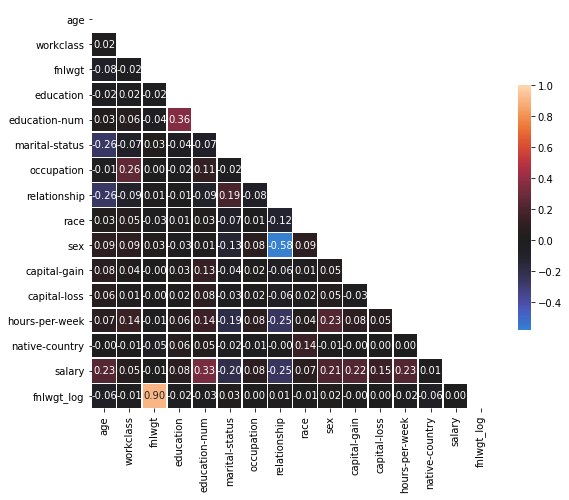

In [ ]:
corr = df_en.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(9,9))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

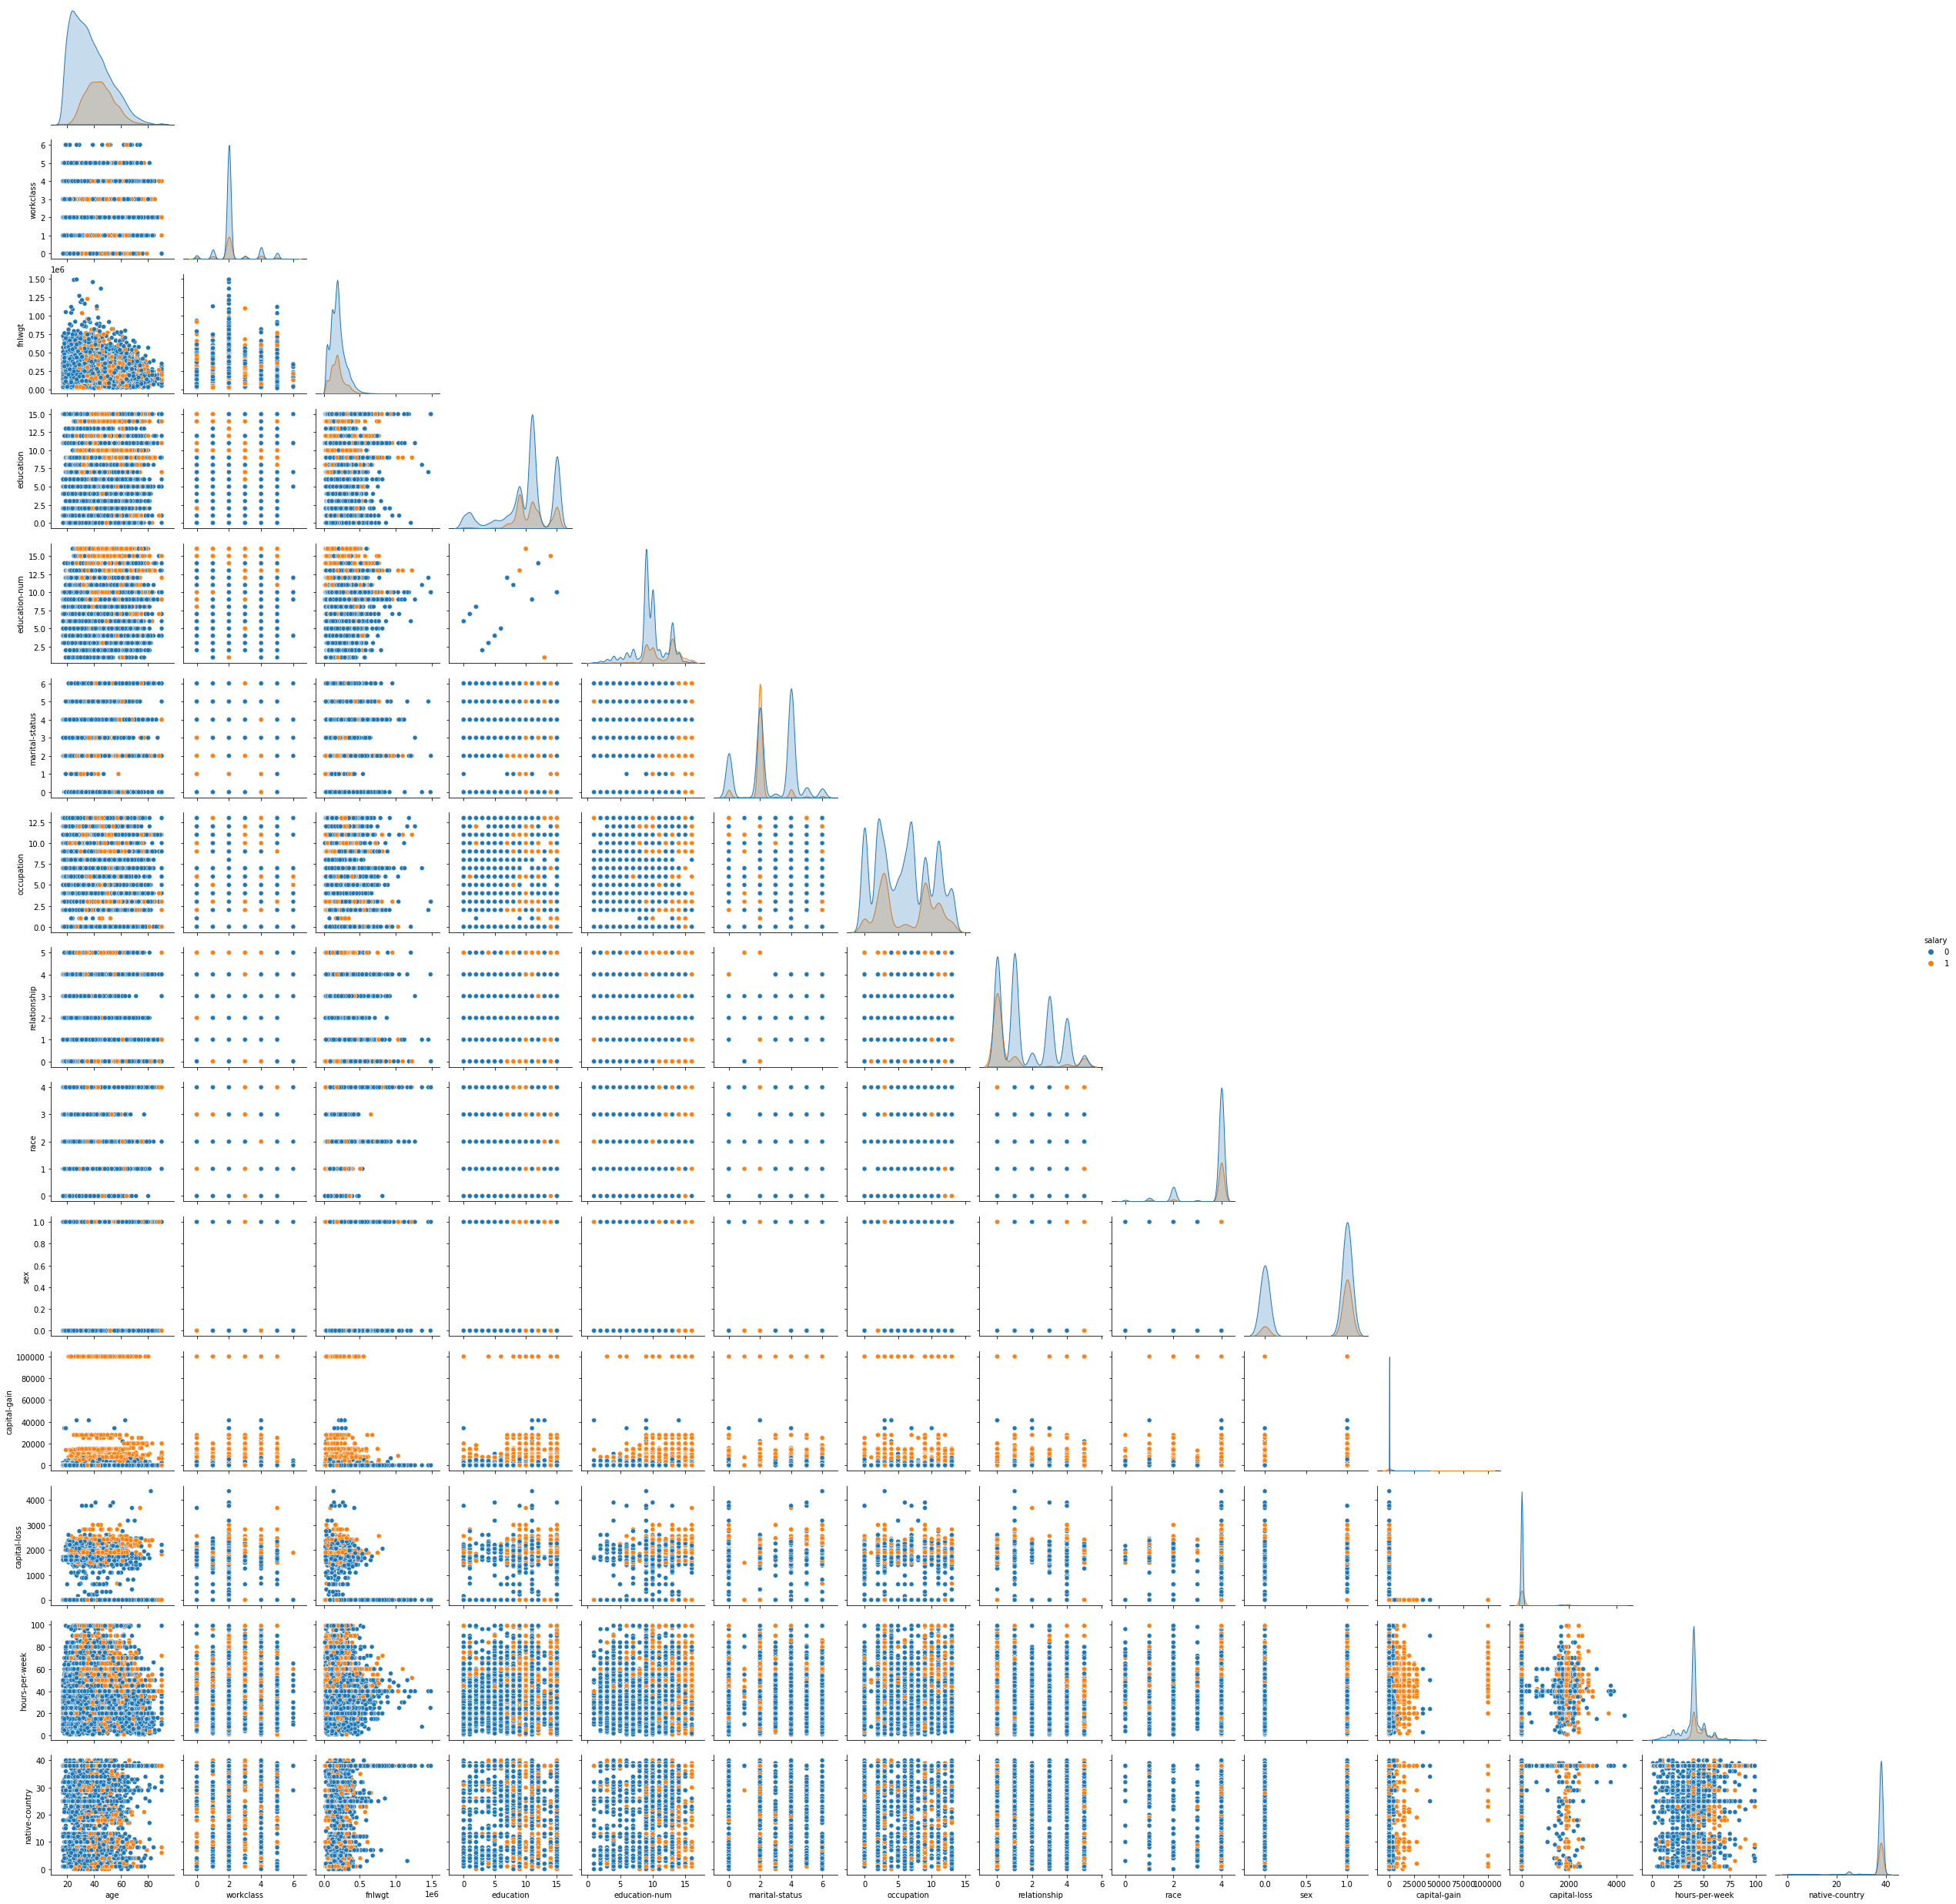

In [ ]:
sns.pairplot(data=df_en, hue='salary', corner=True)

Признаки education-num и education - взаимозаменяющиеся. Это можно проверить отрисовкой кросс-таблицы. Поэтому один признак можно удалить - это education-num.

In [ ]:
# pd.crosstab(df['education-num'],df['education'])

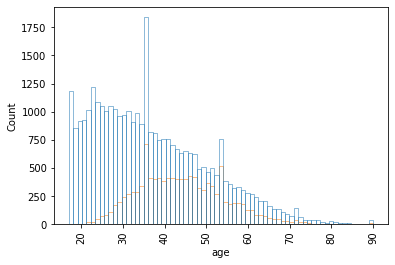

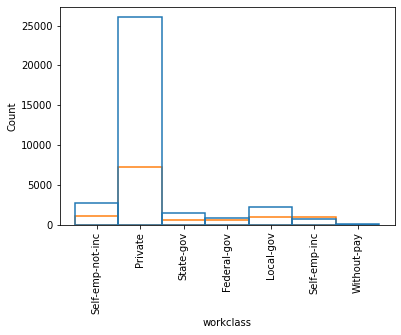

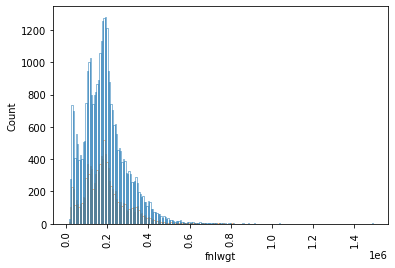

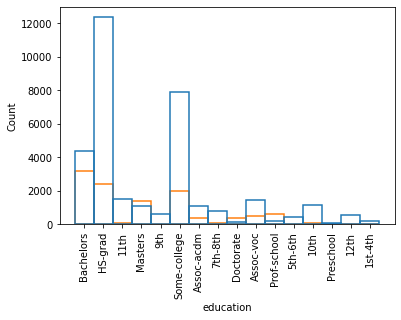

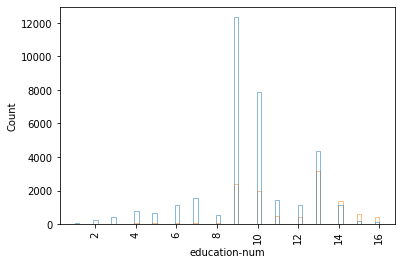

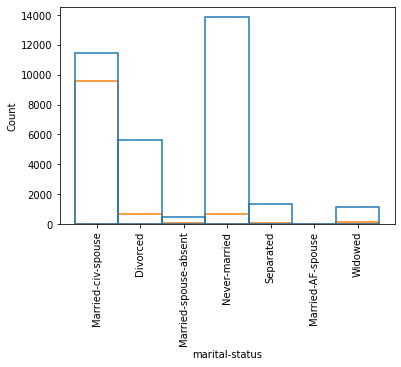

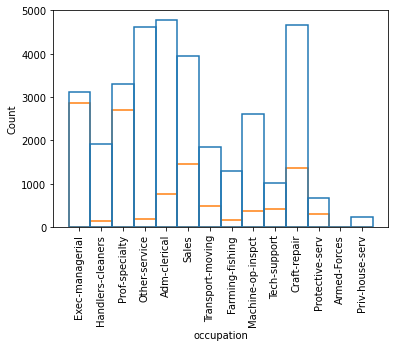

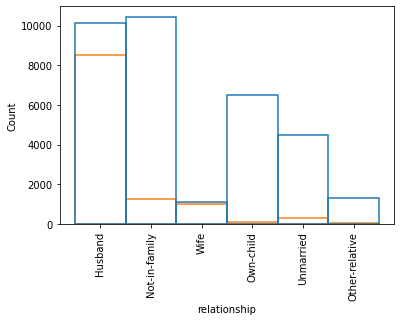

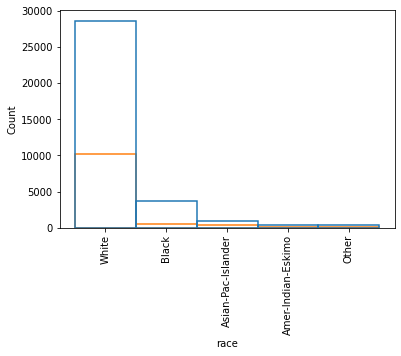

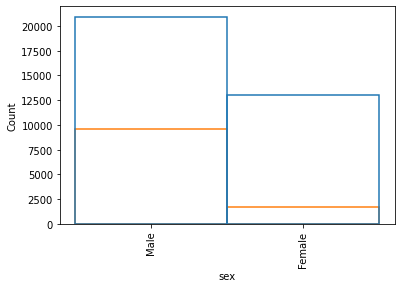

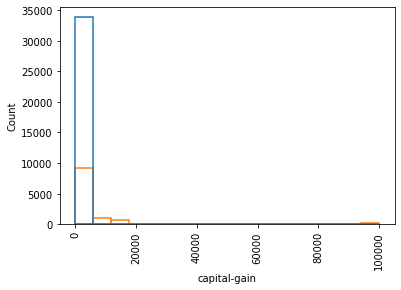

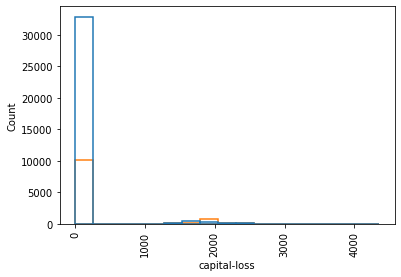

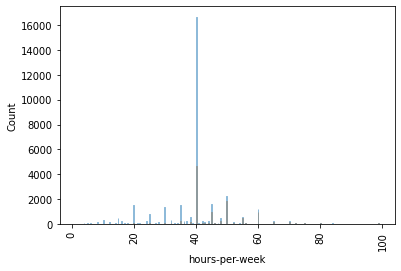

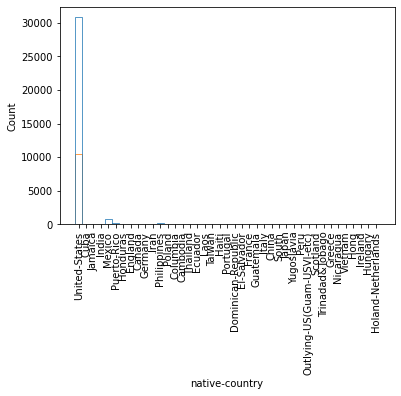

In [ ]:
for feat in list(df.columns)[:-1]:
  sns.histplot(x = feat, data = df_drop,  hue='salary', kde=False, element="bars",
    stat="count", common_norm=False, fill=False, legend=False)
  plt.xticks(rotation=90)
  plt.show()

Проверка интервалов встечаемости класса 1 для признаков hours-per-week и capital-gain путём неотображения максимальных значений в гистограммах для наглядности. 

Используя логику с финансами, имеет смысл ввести допольнительный признак - разница в капитале, равный разнице накопленного и потерянного капитала, поэтому последний можно удалять. Коэффициент корелляции соотносим с накоплением капитала, поэтому возможно один новый признак может заменить все два.

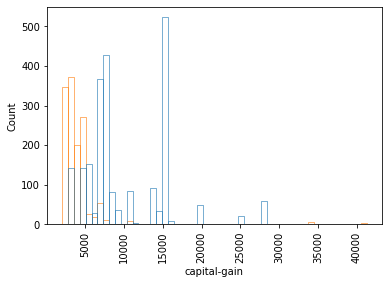

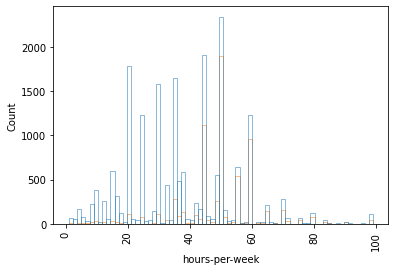

0.22304976785569638
0.1475397217375363
0.2143935872452354


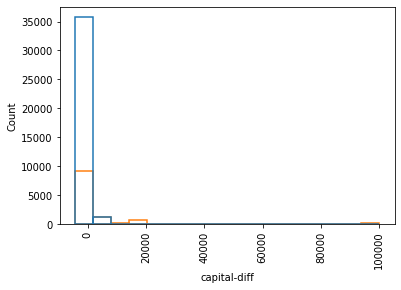

In [49]:
sns.histplot(x = 'capital-gain', data = df[(df['capital-gain']<=90000) & (df['capital-gain']>=2000)],  hue='salary', kde=False, element="bars",
    stat="count", common_norm=False, fill=False, legend=False)
plt.xticks(rotation=90)
plt.show()
sns.histplot(x = 'hours-per-week', data = df[df['hours-per-week']!=40],  hue='salary', kde=False, element="bars",
    stat="count", common_norm=False, fill=False, legend=False)
plt.xticks(rotation=90)
plt.show()

df['capital-diff'] = df['capital-gain'] - df['capital-loss']
df_fill['capital-diff'] = df_fill['capital-gain'] - df_fill['capital-loss']
df_drop['capital-diff'] = df_drop['capital-gain'] - df_drop['capital-loss']

print(np.corrcoef(df_en['salary'], df['capital-gain'])[0][1])
print(np.corrcoef(df_en['salary'], df['capital-loss'])[0][1])
print(np.corrcoef(df_en['salary'], df['capital-diff'])[0][1])

sns.histplot(x = 'capital-diff', data = df,  hue='salary', kde=False, element="bars",
    stat="count", common_norm=False, fill=False, legend=False)
plt.xticks(rotation=90)
plt.show()

Z score
48789 - 1170 = 47619
Deleted 2 %
IQR
48789 - 4378 = 44411
Deleted 8 %


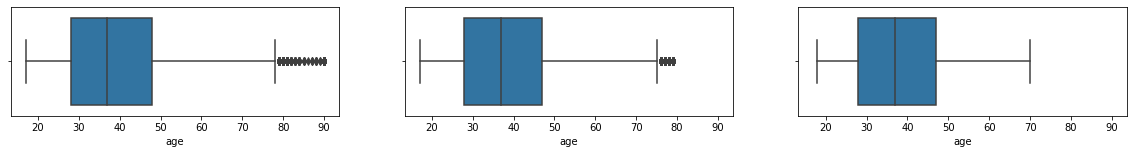

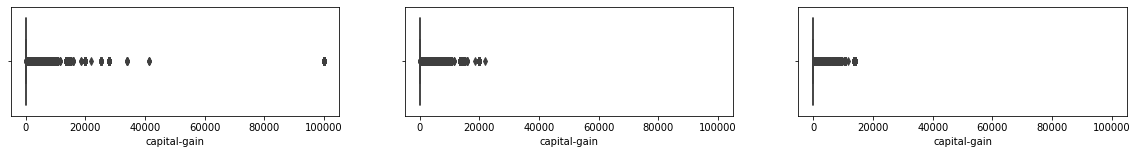

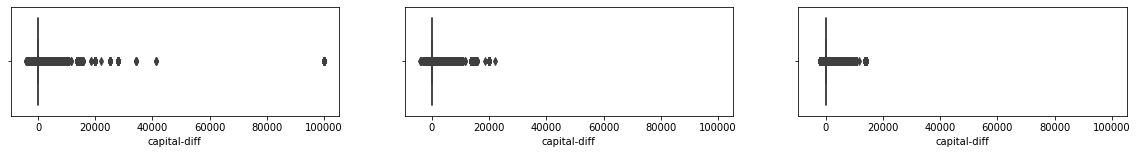

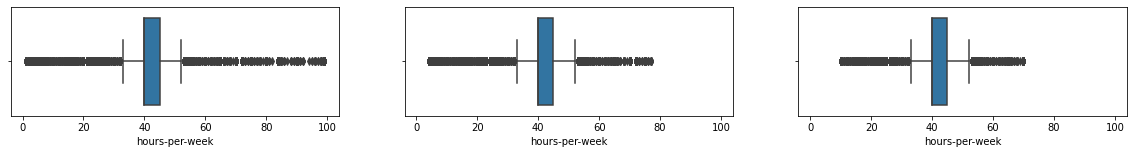

In [61]:
outliers_features = ['age', 'capital-gain', 'capital-diff', 'hours-per-week']
def clean_z(data):
  z_scores = zscore(data[outliers_features])
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < 3).all(axis=1)
  df_clean = data[filtered_entries]
  return df_clean

print('Z score')
df_clean_z = clean_z(df)
print(df.shape[0], '-', df.shape[0]-df_clean_z.shape[0], '=',df_clean_z.shape[0])
print('Deleted', (100*(df.shape[0]-df_clean_z.shape[0]))//df.shape[0], '%')

def clean_q(data):
  df_clean = data.copy()
  Q1 = df[outliers_features].quantile(0.02)
  Q3 = df[outliers_features].quantile(0.98)
  for feat in outliers_features:
    df_clean = df_clean[(df_clean[feat]>=Q1[feat]) & (df_clean[feat]<=Q3[feat])]
  return df_clean
  
print('IQR')
df_clean_q = clean_q(df)
print(df.shape[0], '-',  df.shape[0]-df_clean_q.shape[0], '=',df_clean_q.shape[0])
print('Deleted', (100*(df.shape[0]-df_clean_q.shape[0]))//df.shape[0], '%')

def clean_none(data):
  return data

for idx, feat in  enumerate(outliers_features):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,2), sharex=True)
  sns.boxplot(x=feat, data=df, ax=axes[0], orient='h')
  sns.boxplot(x=feat, data=df_clean_z, ax=axes[1], orient='h')
  sns.boxplot(x=feat, data=df_clean_q, ax=axes[2], orient='h')
  plt.show()

In [10]:
def rfc_clf(x_train, x_test, y_train, y_test):
  clf = RandomForestClassifier()
  cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                              cv=5, scoring=['accuracy', 'f1_weighted'])
  return 'RFC', '-', np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_f1_weighted'])

In [11]:
def gnb_clf(x_train, x_test, y_train, y_test):
  all_predictions = []
  all_predictions_f = []
  gnb = GaussianNB()
  gnb.fit(x_train, y_train)
  gnb_pred_test = gnb.predict(x_test)
  all_predictions.append(accuracy_score(y_test, gnb_pred_test))
  all_predictions_f.append(f1_score(y_test, gnb_pred_test))
      
  best_param = np.argmax(all_predictions)+2
  best_score = np.max(all_predictions)
  best_f1 = np.max(all_predictions_f)
  return 'GNB', '-', best_score, best_f1

In [12]:
def cnb_clf(x_train, x_test, y_train, y_test):
  all_predictions = []
  all_predictions_f = []
  сnb = CategoricalNB()
  сnb.fit(x_train, y_train)
  сnb_pred_test = сnb.predict(x_test)
  all_predictions.append(accuracy_score(y_test, сnb_pred_test))
  all_predictions_f.append(f1_score(y_test, сnb_pred_test))
      
  best_param = np.argmax(all_predictions)+2
  best_score = np.max(all_predictions)
  best_f1 = np.max(all_predictions_f)
  return 'СNB', '-', best_score, best_f1

In [13]:
def knn_clf(x_train, x_test, y_train, y_test):
  knn_params = list(range(2, 10))
  all_predictions = []
  all_predictions_f = []
  for d in knn_params:
      clf = KNeighborsClassifier(n_neighbors=d)
      cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                  cv=5, scoring=['accuracy', 'f1_weighted'])
      all_predictions.append(np.mean(cv_results['test_accuracy']))
      all_predictions_f.append(np.mean(cv_results['test_f1_weighted']))
      
  best_param = np.argmax(all_predictions)+2
  best_score = np.max(all_predictions)
  best_recall = all_predictions_f[np.argmax(all_predictions)]
  return 'KNN', best_param, best_score, best_recall

In [14]:
def svm_clf(x_train, x_test, y_train, y_test):
  kernels=['linear', 'poly', 'rbf', 'sigmoid']
  all_predictions = []
  all_predictions_f = []
  for k in kernels:
    clf = svm.SVC(kernel=k, C=10)
    cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                cv=2, scoring=['accuracy', 'f1_weighted'])
    all_predictions.append(np.mean(cv_results['test_accuracy']))
    all_predictions_f.append(np.mean(cv_results['test_f1_weighted']))
  best_param = kernels[np.argmax(all_predictions)]
  best_score = np.max(all_predictions)
  best_recall = all_predictions_f[np.argmax(all_predictions)]
  return 'SVM', best_param, best_score, best_recall

In [15]:
def log_clf(x_train, x_test, y_train, y_test):
  clf = LogisticRegression(max_iter=600)
  cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                cv=5, scoring=['accuracy', 'f1_weighted'])
  return 'Log', '-', np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_f1_weighted'])

In [16]:
def abc_clf(x_train, x_test, y_train, y_test):
  clf = AdaBoostClassifier()
  cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                cv=5, scoring=['accuracy', 'f1_weighted'])
  return 'ABC', '-', np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_f1_weighted'])

Как было написано выше, некоторые признаки - бесполезны, их мы сразу выкидываем.

Из графиков выше видно, что некоторые признаки можно упростить. Образование в несколько класссов можно объединить в школьное, т.к. статистически там нет класса 1, только класс 0.

Также можно упростить расы.

Также можно создать отдельную копию датасета, где все переменные - категориальные, а интервалы для развибки взяты из графиков выше.

In [50]:
used_df = df_clean_z
def unite_feats(data):
  df_proc = data.drop(columns=['fnlwgt', 'capital-loss', 'native-country', 'education-num', 'salary']).copy()
  df_proc['education'].replace(['11th', '9th', '7th-8th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], 'School', inplace = True)
  df_proc['race'].replace(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],' Other', inplace = True)
  return df_proc
df_proc = unite_feats(used_df)

df_proc_cat = df_proc.copy()
df_proc_cat['capital-gain'] = pd.cut(df_proc['capital-gain'], bins = [-1, 8000, 100000], labels = ['Minor', 'Major'])
df_proc_cat['capital-diff'] = pd.cut(df_proc['capital-diff'], bins = [-5000, 5000, 100000], labels = ['Minor', 'Major'])
df_proc_cat['age'] = pd.cut(df_proc['age'], bins = [0, 25, 35, 55, 70, 100], labels = ['Young','Young-Adult', 'Adult', 'Adult-Old', 'Old'])
df_proc_cat['hours-per-week'] = pd.cut(df_proc['hours-per-week'], bins = [0, 30, 45, 100], labels = ['Less', 'Normal', 'Extra'])

df_proc.head(2)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,capital-diff
0,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,13,0
1,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,40,0


Нужно все категориальные признаки перевести в числа. Но т.к. это категориальные признаки, всё же рационально представить значение каждого признака отдельной колонкой.

In [23]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship','race', 'sex']
le = LabelEncoder()
target = le.fit_transform(used_df['salary'])
# for feat in categorical:
#   df_proc[feat] = le.fit_transform(df_proc[feat])
# for feat in df_proc_cat.columns:
#   df_proc_cat[feat] = le.fit_transform(df_proc_cat[feat])
df_proc = pd.get_dummies(data=df_proc, prefix=categorical, drop_first=True)
df_proc_cat = pd.get_dummies(data=df_proc_cat, drop_first=True)

Поочерёдно вручную используем три датасета: НаН как отдельное значение в признаке, НаН как существующее значение, Нан выброшен.

Все датасеты как исходные задаются выше, но их всех необходимо стандартизировать.

In [ ]:
#очень долгое обучение
# первое лог - не лог, а адабуст
classifiers = [abc_clf, rfc_clf, svm_clf, knn_clf, log_clf, gnb_clf]
train_df = df_proc
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
print('Uses df with ? cleaned by z_score')
print('Not categorial')        
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
for clf in classifiers:
  start = time.time()
  res = clf(x_tr, x_ts, y_tr, y_ts)
  end = time.time()
  print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

train_df = df_proc_cat
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
print('Categorial')        
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
for clf in classifiers:
  start = time.time()
  res = clf(x_tr, x_ts, y_tr, y_ts)
  end = time.time()
  print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

train_df = df_proc_cat
x_tr, x_ts, y_tr, y_ts = train_test_split(train_df, target, test_size=.3, random_state=17)
start = time.time()
res = cnb_clf(x_tr, x_ts, y_tr, y_ts)
end = time.time()
print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

Uses drop cleaned by z_score
Not categorial
Log 0.862 0.86 time: 10.8
RFC 0.848 0.84 time: 19.6
SVM 0.852 0.85 time: 594.4
KNN 0.847 0.84 time: 1355.9
Log 0.854 0.85 time: 3.4
GNB 0.589 0.51 time: 0.0
Categorial
Log 0.857 0.85 time: 10.0
RFC 0.85 0.85 time: 17.4
SVM 0.852 0.85 time: 2540.9
KNN 0.844 0.83 time: 1440.1
Log 0.86 0.85 time: 2.2
GNB 0.6 0.51 time: 0.1
СNB 0.817 0.65 time: 0.1


Из результатов работы алгоритмов видно, что некоторые показывают меньшую точность. 

Из ансаблевых методов, устойчивых к избыточности данных, AdaBoost спраляется лучше, чем RandomForest, поэтому для дальнейшего выбора модели возьмём только её. Из простых моделей показывают эффективность SVM и LogisticRegression. Возможно, KNN при уменьшении размерности даст гораздо больший результат.


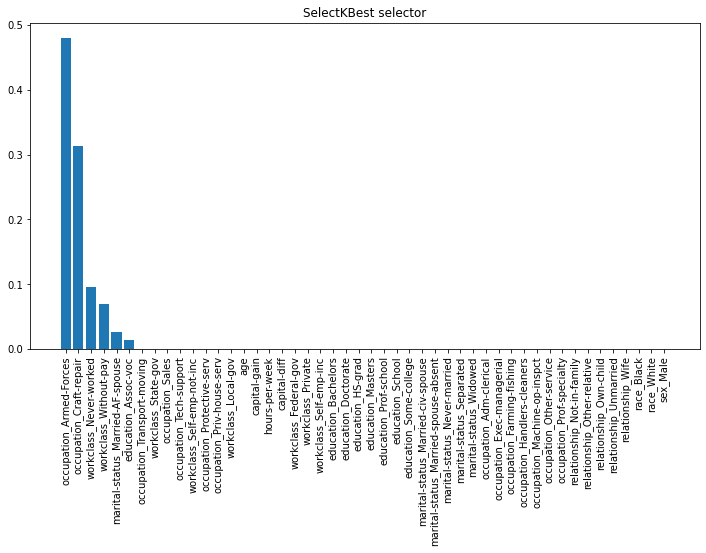

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif
used_df = df_proc
kb_feature_selector = SelectKBest(f_classif, 'all')
kb_feature_selector.fit_transform(used_df, target)
scores = -np.log10(kb_feature_selector.pvalues_ + 1)
scores /= np.nansum(scores)
columns_skb = [x for _, x in sorted(zip(scores, used_df.columns), key=lambda pair: pair[0], reverse=True)]
fig = plt.subplots(figsize =(12, 6)) 
plt.bar(columns_skb, sorted(scores, reverse=True))
plt.title('SelectKBest selector')
plt.xticks(rotation=90)
plt.show()

In [ ]:
important_feats = columns_skb[:8]
classifiers = [abc_clf, rfc_clf, svm_clf, knn_clf, log_clf, gnb_clf]
train_df = df_proc[important_feats]
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
print('Uses df with ? cleaned by z_score')
print('Not categorial')        
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
for clf in classifiers:
  start = time.time()
  res = clf(x_tr, x_ts, y_tr, y_ts)
  end = time.time()
  print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

train_df = df_proc_cat[important_feats]
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
print('Categorial')        
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
for clf in classifiers:
  start = time.time()
  res = clf(x_tr, x_ts, y_tr, y_ts)
  end = time.time()
  print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

train_df = df_proc_cat[important_feats]
x_tr, x_ts, y_tr, y_ts = train_test_split(train_df, target, test_size=.3, random_state=17)
start = time.time()
res = cnb_clf(x_tr, x_ts, y_tr, y_ts)
end = time.time()
print(res[0], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

Uses df with ? cleaned by z_score
Not categorial
ABC 0.78 0.68 time: 15.2
RFC 0.78 0.68 time: 5.1
SVM 0.78 0.68 time: 96.3
KNN 0.78 0.68 time: 314.2
Log 0.78 0.68 time: 0.5
GNB 0.217 0.36 time: 0.0
Categorial
ABC 0.78 0.68 time: 16.4
RFC 0.78 0.68 time: 4.8
SVM 0.78 0.68 time: 96.3
KNN 0.78 0.68 time: 315.0
Log 0.78 0.68 time: 0.5
GNB 0.217 0.36 time: 0.0
СNB 0.784 0.0 time: 0.0


Радикальное снижение размерности до только важных фич, используя selectKBest привело к общему ухудшению качества классификации. Исходя из этого можно заключить, что эта селекция признаков не работает. Из-за того, что модели долго обучаются, придётся сразу выбирать используемую модель. Пусть это будут AdaBoost и LogisticRegression, потому что быстро обучаются. Проверим, как постепенное снижение размерности сказывается на качестве классификаторов. Но перед этим используем автоматический подсчёт важности признаков для этих моделей.

In [25]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
output.clear()

In [30]:
train_df = df_proc
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
model = LogisticRegression().fit(x_tr, y_tr)
perm = PermutationImportance(model).fit(x_ts, y_ts)

importance = perm.feature_importances_
columns_lr = [x for _, x in sorted(zip(importance, train_df.columns), key=lambda pair: pair[0], reverse=True)]

eli5.show_weights(perm, feature_names=train_df.columns.tolist())

Weight,Feature
0.0434 ± 0.0018,capital-diff
0.0348 ± 0.0025,marital-status_Married-civ-spouse
0.0085 ± 0.0015,education_School
0.0080 ± 0.0014,occupation_Exec-managerial
0.0070 ± 0.0024,education_HS-grad
0.0048 ± 0.0013,hours-per-week
0.0048 ± 0.0020,occupation_Prof-specialty
0.0043 ± 0.0029,age
0.0042 ± 0.0017,relationship_Wife
0.0031 ± 0.0007,education_Bachelors


In [31]:
train_df = df_proc_cat
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
model = LogisticRegression().fit(x_tr, y_tr)
perm = PermutationImportance(model).fit(x_ts, y_ts)

importance = perm.feature_importances_
columns_lr_cat = [x for _, x in sorted(zip(importance, train_df.columns), key=lambda pair: pair[0], reverse=True)]

eli5.show_weights(perm, feature_names=train_df.columns.tolist())

Weight,Feature
0.0432 ± 0.0043,age_Adult
0.0399 ± 0.0036,marital-status_Married-civ-spouse
0.0169 ± 0.0029,hours-per-week_Extra
0.0146 ± 0.0009,age_Adult-Old
0.0135 ± 0.0034,hours-per-week_Normal
0.0131 ± 0.0007,capital-diff_Major
0.0113 ± 0.0017,age_Young-Adult
0.0107 ± 0.0009,capital-gain_Major
0.0064 ± 0.0010,education_School
0.0054 ± 0.0015,education_HS-grad


In [32]:
train_df = df_proc
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
model = AdaBoostClassifier()
model.fit(x_tr, y_tr)
perm = PermutationImportance(model).fit(x_ts, y_ts)

importance = perm.feature_importances_
columns_ada_perm = [x for _, x in sorted(zip(importance, train_df.columns), key=lambda pair: pair[0], reverse=True)]
columns_ada_ada = [x for _, x in sorted(zip(model.feature_importances_, train_df.columns), key=lambda pair: pair[0], reverse=True)]

eli5.show_weights(perm, feature_names=train_df.columns.tolist())

Weight,Feature
0.0473 ± 0.0038,marital-status_Married-civ-spouse
0.0356 ± 0.0021,capital-gain
0.0182 ± 0.0026,education_HS-grad
0.0172 ± 0.0027,education_School
0.0144 ± 0.0026,age
0.0060 ± 0.0033,hours-per-week
0.0052 ± 0.0013,education_Some-college
0.0051 ± 0.0008,capital-diff
0.0049 ± 0.0018,occupation_Prof-specialty
0.0026 ± 0.0009,occupation_Exec-managerial


In [ ]:
fig = plt.subplots(figsize =(12, 8)) 
depth = np.arange(5, 50, 5)

rfc_not_cat_res = []
rfc_cat_res = []


for d in depth:
  clf = RandomForestClassifier(depth = d)
  stand_df = scaler.fit_transform(df_proc)
  cv_results = cross_validate(clf, stand_df, target, cv=5, scoring=['accuracy'])
  rfc_not_cat_res.append(np.mean(cv_results['test_accuracy']))

  stand_df = scaler.fit_transform(df_proc_cat)
  cv_results = cross_validate(clf, stand_df, target, cv=5, scoring=['accuracy'])
  rfc_cat_res.append(np.mean(cv_results['test_accuracy']))


plt.plot(depth, rfc_not_cat_res, '.-', color='r', label='RFC_not_cat')
plt.plot(depth, rfc_cat_res, '--', color='r', label='RFC_cat')

plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.3, 0.9)
plt.grid()
plt.xticks()
plt.show()

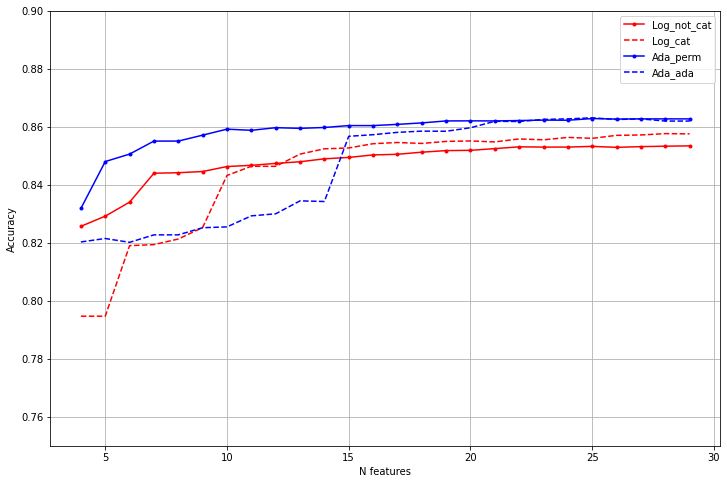

In [39]:
fig = plt.subplots(figsize =(12, 8)) 
n_features = np.arange(4, 30)

lr_not_cat_res = []
lr_cat_res = []
ada_ada_res = []
ada_perm_res = []

for n_feat in n_features:
  stand_df = scaler.fit_transform(df_proc[columns_lr[:n_feat]])
  x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
  lr_not_cat_res.append(log_clf(x_tr, x_ts, y_tr, y_ts)[2])

  stand_df = scaler.fit_transform(df_proc_cat[columns_lr_cat[:n_feat]])
  x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
  lr_cat_res.append(log_clf(x_tr, x_ts, y_tr, y_ts)[2])

  stand_df = scaler.fit_transform(df_proc[columns_ada_perm[:n_feat]])
  x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
  ada_perm_res.append(abc_clf(x_tr, x_ts, y_tr, y_ts)[2])

  stand_df = scaler.fit_transform(df_proc[columns_ada_ada[:n_feat]])
  x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
  ada_ada_res.append(abc_clf(x_tr, x_ts, y_tr, y_ts)[2])

plt.plot(n_features, lr_not_cat_res, '.-', color='r', label='Log_not_cat')
plt.plot(n_features, lr_cat_res, '--', color='r', label='Log_cat')
plt.plot(n_features, ada_perm_res, '.-', color='b', label='Ada_perm')
plt.plot(n_features, ada_ada_res, '--', color='b', label='Ada_ada')

plt.xlabel('N features')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.75, 0.9)
plt.grid()
plt.xticks()
plt.show()

Если упростить график, то практически лучшее значение классификаторов достигается AdaBoost уже при 10 признаках, отобранных при помощи PermutationImportance. 

In [69]:
used_df = [df, df_fill, df_drop]
print_used_df = ['Using ?', 'Filled nans', 'Drop nans']
cleaning = [clean_none, clean_z, clean_q]
print_cleaning = ['With outliers', 'Cleaned Z', 'Cleaned Q']
feats = columns_ada_perm[:10]
ada = AdaBoostClassifier()

print('Used features: ', feats, '\n')
for idx, ud in enumerate(used_df):
  print('-------------------------------')
  print(print_used_df[idx])
  print('-------------------------------')
  for idc, uc in enumerate(cleaning):
    print(print_cleaning[idc])
    df_train = uc(ud)
    y = le.fit_transform(df_train['salary'])
    df_train = pd.get_dummies(data=unite_feats(df_train), prefix=categorical, drop_first=True)
    df_train = df_train[feats]
    df_train = scaler.fit_transform(df_train)
    cv_res = cross_validate(ada, df_train, y, scoring=['accuracy', 'recall'], cv=5)

    print('Accuracy: ', np.mean(cv_res['test_accuracy']))
    print('Recall: ',np.mean(cv_res['test_recall']))
    print()

Used features:  ['marital-status_Married-civ-spouse', 'capital-gain', 'education_HS-grad', 'education_School', 'age', 'hours-per-week', 'education_Some-college', 'capital-diff', 'occupation_Prof-specialty', 'occupation_Exec-managerial'] 

-------------------------------
Using ?
-------------------------------
With outliers
Accuracy:  0.8582877302336929
Recall:  0.6095352606373936

Cleaned Z
Accuracy:  0.8588588811023318
Recall:  0.6060687788758657

Cleaned Q
Accuracy:  0.8548107635494511
Recall:  0.5653884964682139

-------------------------------
Filled nans
-------------------------------
With outliers
Accuracy:  0.8582877302336929
Recall:  0.6095352606373936

Cleaned Z
Accuracy:  0.8588588811023318
Recall:  0.6060687788758657

Cleaned Q
Accuracy:  0.8548107635494511
Recall:  0.5653884964682139

-------------------------------
Drop nans
-------------------------------
With outliers
Accuracy:  0.8539867945224209
Recall:  0.6138162172499523

Cleaned Z
Accuracy:  0.8536409483852504
Reca

Дучшие результаты показывают данные без нанов с выбросами.

Теперь оценим итоговую модель. И покажем, как важно использовать кросс-валидацию.

In [76]:
ada = AdaBoostClassifier()
df_train = df_drop
y_train = le.fit_transform(df_train['salary'])
df_train = pd.get_dummies(data=unite_feats(df_train), prefix=categorical, drop_first=True)
df_train = df_train[feats]
df_train = scaler.fit_transform(df_train)
x, y = shuffle(df_train, y_train)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.3, random_state=14)
ada.fit(x_tr, y_tr)
res = ada.predict(x_ts)
cv_results = cross_validate(ada, x, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'roc_auc'])
print("Score cv: ", np.mean(cv_results['test_accuracy']))
print("Score: ", accuracy_score(y_ts, res))
print("\nPrecision cv: ", np.mean(cv_results['test_precision']))
print("Precision: ", precision_score(y_ts, res))
print("\nRecall cv: ", np.mean(cv_results['test_recall']))
print("Recall: ", recall_score(y_ts, res))
print("\nROC AUC cv: ", np.mean(cv_results['test_roc_auc']))
# print("ROC AUC: ", roc_auc_score(y_ts, ada.predict_proba(x_ts)))
print("\nConfusion matrix: \n", confusion_matrix(y_ts, res))

Score cv:  0.8542967102450939
Score:  0.8525787648491109

Precision cv:  0.7525174892550275
Precision:  0.7583518930957683

Recall cv:  0.6146233346082743
Recall:  0.6026548672566372

ROC AUC cv:  0.9089582963446071

Confusion matrix: 
 [[9512  651]
 [1347 2043]]
